<a href="https://colab.research.google.com/github/Tonmoy-saha18/anomaly-detection/blob/main/anomaly_detection_using_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/autoencoders/transaction_report.xlsx")
df.isna().sum()

id                                                 0
create_date_time                                  30
created_by                                        30
is_deleted                                         0
update_date_time                                  30
updated_by                                        30
amount                                             0
bank_transaction_reference                     10571
depositor_running_balance                       1407
dispute_remarks                                11933
dispute_status                                 11933
fee_amount                                       213
from_account                                     643
from_account_name                                310
original_transaction_reference_for_reversal    11933
receiver_account_type                           1620
receiver_credit_amount                          1132
receiver_idp_id                                 4985
remarks                                       

In [ ]:
df.head()

,id,create_date_time,created_by,is_deleted,update_date_time,updated_by,amount,bank_transaction_reference,depositor_running_balance,dispute_remarks,...,fee_description,fee_payer_internal_account,vat_payer_internal_account,subsidy_id,subsidy_amount,subsidy_type,anonymous_donor,is_shared_fee,incentive_payment_type,incentive_amount
0,82C2CE8B-0F5D-421F-9C03-000B585D1582,2024-02-06 12:20:12.9668620,acb60f74-1ec5-4f94-8402-a8151beba257,False,2024-02-06 12:20:12.9668620,acb60f74-1ec5-4f94-8402-a8151beba257,23.45,NaN,1608.96,NaN,...,Fixed Fee: Amount: 5.00 TTD,2.310121e+18,2.310121e+18,NaN,0.0,NO_SUBSIDY,0.0,True,NaN,0.0
1,790D6B47-2454-43D3-8DAB-0012F8E01389,2024-02-20 00:00:00.7394836,scheduler,False,2024-02-20 00:00:00.7394836,scheduler,10.00,NaN,1840.53,NaN,...,NaN,2.710574e+18,2.710574e+18,NaN,NaN,NaN,0.0,False,NaN,NaN
2,85F1C24D-57D1-4866-8030-00155C572EB9,2023-08-17 13:16:56.5215958,e550d658-7aee-4a37-a37f-66b0a6f54696,False,2023-08-17 13:16:56.5215958,e550d658-7aee-4a37-a37f-66b0a6f54696,35.90,utgh,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
3,7CDB7161-E35C-4EC2-94B5-001D60DB1C59,2022-05-17 18:12:32.3453923,unknown,False,2022-05-17 18:12:32.3453923,unknown,1050.00,NaN,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
4,E29CBD81-1AD5-4AE2-8DD9-002374B066E4,2023-01-31 17:54:54.8226750,ce84f1fb-5ea0-42e7-a17f-2479b7c3d452,False,2023-01-31 17:54:54.8226750,ce84f1fb-5ea0-42e7-a17f-2479b7c3d452,58.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN


In [ ]:
df['timestamp'] = pd.to_datetime(df['create_date_time'])
df = df.sort_values('timestamp')
print(df['timestamp'])

485     2022-04-08 06:53:07.343726600
2620    2022-04-08 07:21:00.771765300
2278    2022-04-08 09:01:34.774890200
6848    2022-04-08 09:05:27.942540300
5992    2022-04-08 09:34:08.485949500
                     ...             
10746                             NaT
10944                             NaT
10998                             NaT
11226                             NaT
11622                             NaT
Name: timestamp, Length: 11933, dtype: datetime64[ns]


In [ ]:
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
dropable_column = ['id', 'is_deleted', 'receiver_idp_id', 'sender_idp_id', 'workflow_request_id', 'request_id', 'merchant_id', 'transaction_id', 'transaction_category_id', 'branch_id', 'subsidy_id']
df.drop(dropable_column, axis=1, inplace=True)
df.head()

,create_date_time,created_by,update_date_time,updated_by,amount,bank_transaction_reference,depositor_running_balance,dispute_remarks,dispute_status,fee_amount,...,vat_payer_internal_account,subsidy_amount,subsidy_type,anonymous_donor,is_shared_fee,incentive_payment_type,incentive_amount,timestamp,hour_of_day,day_of_week
485,2022-04-08 06:53:07.3437266,unknown,2022-04-08 06:53:07.3437266,unknown,120.00,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,2022-04-08 06:53:07.343726600,6.0,4.0
2620,2022-04-08 07:21:00.7717653,unknown,2022-04-08 07:21:40.7896891,unknown,500.00,1234632,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,2022-04-08 07:21:00.771765300,7.0,4.0
2278,2022-04-08 09:01:34.7748902,unknown,2022-04-08 09:03:20.8746794,unknown,0.00,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,2022-04-08 09:01:34.774890200,9.0,4.0
6848,2022-04-08 09:05:27.9425403,unknown,2022-04-08 09:05:58.7246023,unknown,300.13,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,2022-04-08 09:05:27.942540300,9.0,4.0
5992,2022-04-08 09:34:08.4859495,unknown,2022-04-08 09:34:08.4859495,unknown,366.00,uv8fif8r7e36r8y9u8g7dihij9g7ducihoh8,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,2022-04-08 09:34:08.485949500,9.0,4.0


In [ ]:
df.columns

Index(['create_date_time', 'created_by', 'update_date_time', 'updated_by',
       'amount', 'bank_transaction_reference', 'depositor_running_balance',
       'dispute_remarks', 'dispute_status', 'fee_amount', 'from_account',
       'from_account_name', 'original_transaction_reference_for_reversal',
       'receiver_account_type', 'receiver_credit_amount', 'remarks',
       'sender_account_type', 'sender_debit_amount', 'status', 'to_account',
       'to_account_name', 'transaction_date_time', 'transaction_type',
       'user_note', 'withdrawer_running_balance', 'receiver_country_code',
       'receiver_phone_number', 'sender_country_code', 'sender_phone_number',
       'transaction_code', 'vat_amount', 'transaction_reference',
       'from_internal_account', 'to_internal_account',
       'reversed_transaction_ref', 'fee_payer', 'vat_payer', 'fee_description',
       'fee_payer_internal_account', 'vat_payer_internal_account',
       'subsidy_amount', 'subsidy_type', 'anonymous_donor', 'i

In [ ]:
df.shape

(11933, 49)

In [ ]:
numerical_columns = ['amount', 'depositor_running_balance','fee_amount','receiver_credit_amount','sender_debit_amount','withdrawer_running_balance']
features = df[numerical_columns]

features.isna().sum()

amount                           0
depositor_running_balance     1407
fee_amount                     213
receiver_credit_amount        1132
sender_debit_amount           1030
withdrawer_running_balance    1653
dtype: int64

In [ ]:
features = features.dropna()

print(features)

       amount  depositor_running_balance  fee_amount  receiver_credit_amount  \
7547    13.00                   20412.31         3.0                   13.00   
8267     5.00                     589.70         3.0                    5.00   
10305   10.00                   19897.59         5.0                   10.00   
9751     1.00                   19816.93         5.0                    1.00   
57       1.00                   19817.93         5.0                    1.00   
...       ...                        ...         ...                     ...   
10746    2.00                   26917.22         0.0                    2.00   
10944    6.70                  152536.00         0.0                    6.70   
10998    7.56                   49917.92         3.0                    7.56   
11226   50.00                   48864.88         3.0                   50.00   
11622   20.00                     122.00         0.0                   20.00   

       sender_debit_amount  withdrawer_

In [ ]:
features.shape

(10204, 6)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
sc.fit(features)
features = sc.transform(features)

In [ ]:
train_data, test_data = train_test_split(
    features, test_size=0.2, random_state=21
)

In [ ]:
train_data

array([[4.99000005e-06, 5.49044246e-02, 8.00000000e-03, 5.99999400e-06,
        4.99000005e-06, 3.49491333e-02],
       [9.99000010e-06, 1.99231093e-04, 0.00000000e+00, 1.09999890e-05,
        9.99000010e-06, 2.65594501e-05],
       [4.99900005e-05, 3.02696066e-03, 1.20000000e-02, 5.09999490e-05,
        4.99900005e-05, 8.91686194e-01],
       ...,
       [9.90000010e-07, 3.53081009e-04, 0.00000000e+00, 1.99999800e-06,
        9.90000010e-07, 2.65594501e-06],
       [2.20000002e-07, 7.73692515e-02, 0.00000000e+00, 1.22999877e-06,
        2.20000002e-07, 2.03002730e-05],
       [1.19900001e-05, 4.67832288e-02, 1.20000000e-02, 1.29999870e-05,
        1.19900001e-05, 3.50789072e-02]])

In [ ]:
n_shape = train_data.shape[1]
n_shape

6

In [ ]:
# encoder = tf.keras.Sequential(name='encoder')
# encoder.add(layer=layers.Dense(units=10, activation='relu', input_shape=[n_shape]))
# encoder.add(layers.Dropout(0.1))
# encoder.add(layer=layers.Dense(units=5, activation='relu'))
# encoder.add(layer=layers.Dense(units=2, activation='relu'))

# decoder = tf.keras.Sequential(name='decoder')
# decoder.add(layer=layers.Dense(units=5, activation='relu'))
# decoder.add(layers.Dropout(0.1))
# decoder.add(layer=layers.Dense(units=10, activation='relu'))
# decoder.add(layer=layers.Dense(units=n_shape, activation='sigmoid'))

# autoencoder = tf.keras.Sequential([encoder, decoder])

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(30, activation="relu", input_shape=[n_shape]),
      layers.Dense(20, activation="relu"),
      layers.Dense(5, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(20, activation="relu"),
      layers.Dense(30, activation="relu"),
      layers.Dense(n_shape, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(train_data, train_data,
          epochs=500,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/500
16/16 [==============================] - 2s 27ms/step - loss: 0.4865 - val_loss: 0.4777
Epoch 2/500
16/16 [==============================] - 0s 8ms/step - loss: 0.4649 - val_loss: 0.4463
Epoch 3/500
16/16 [==============================] - 0s 8ms/step - loss: 0.4173 - val_loss: 0.3743
Epoch 4/500
16/16 [==============================] - 0s 8ms/step - loss: 0.3127 - val_loss: 0.2291
Epoch 5/500
16/16 [==============================] - 0s 7ms/step - loss: 0.1493 - val_loss: 0.0726
Epoch 6/500
16/16 [==============================] - 0s 8ms/step - loss: 0.0410 - val_loss: 0.0220
Epoch 7/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0174 - val_loss: 0.0156
Epoch 8/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 9/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 10/500
16/16 [==============================] - 0s 9ms/step - loss: 0.0137 - val_loss: 0.0140
Epoch 11

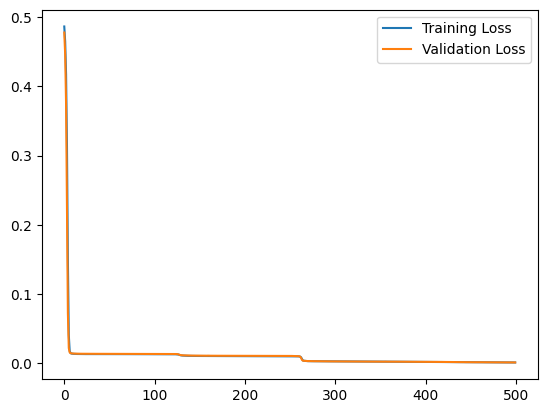

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
# Reshape the test data to match the input layer of the encoder
test_data_reshaped = test_data.reshape((test_data.shape[0], n_shape))

# Encode the reshaped test data
encoded_data = autoencoder.encoder(test_data_reshaped).numpy()

# Decode the encoded data
decoded_data = autoencoder.decoder(encoded_data).numpy()

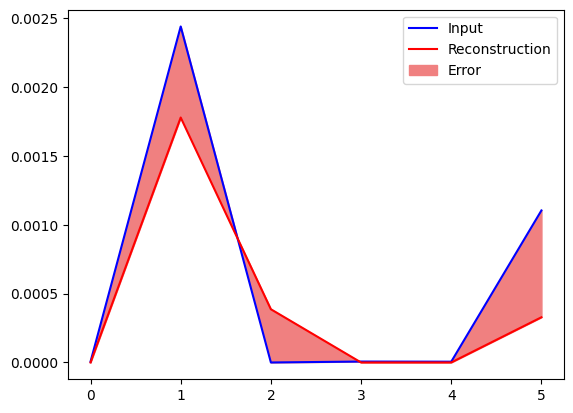

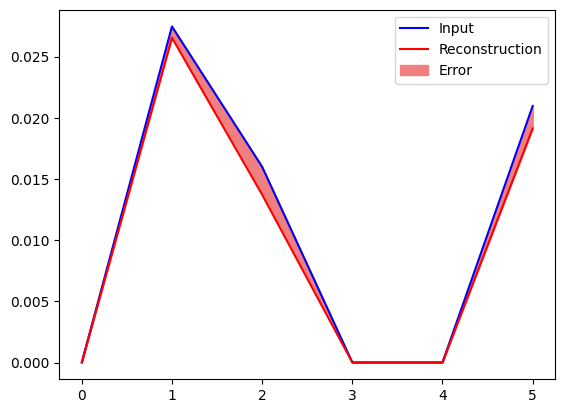

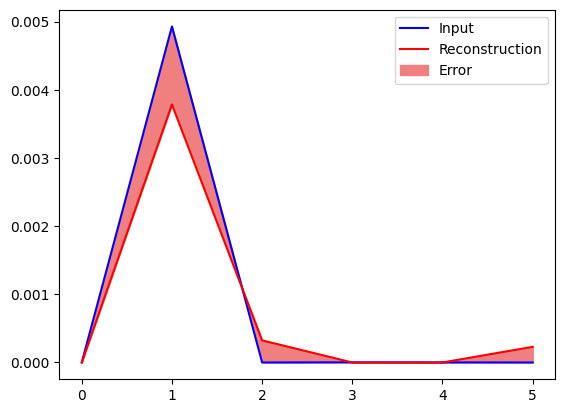

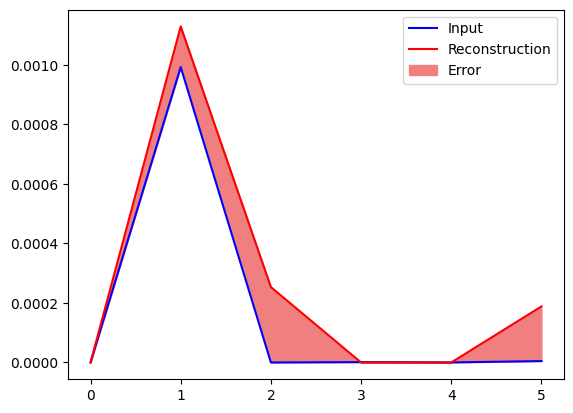

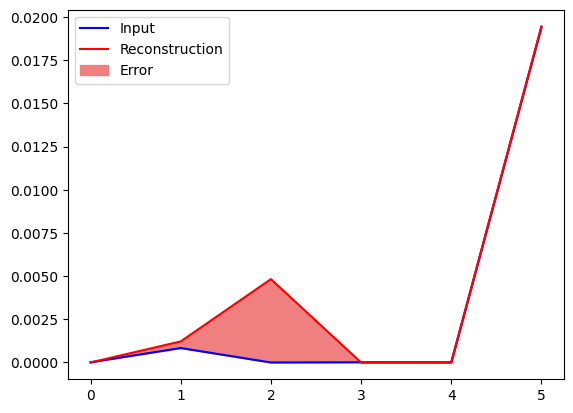

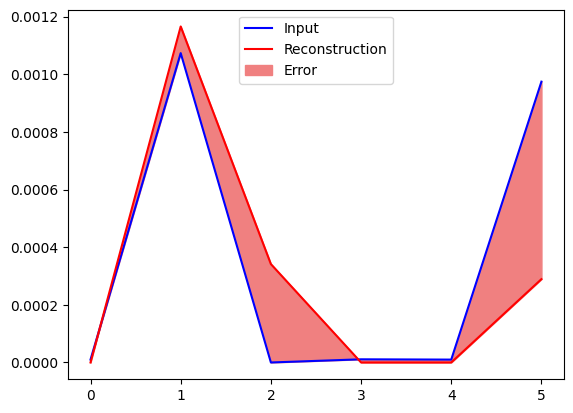

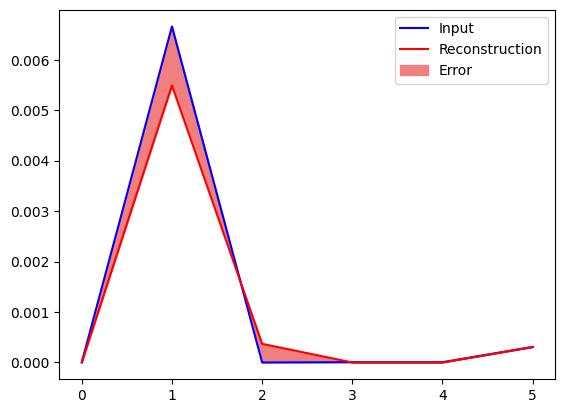

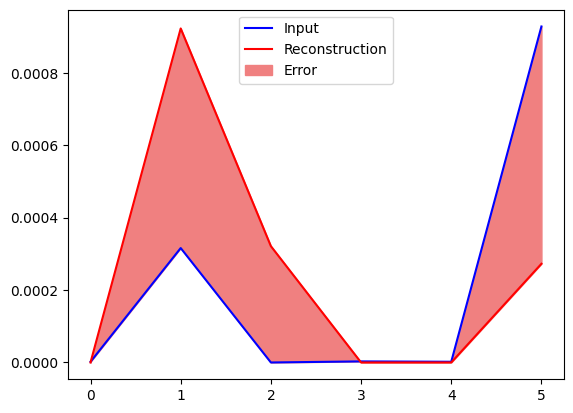

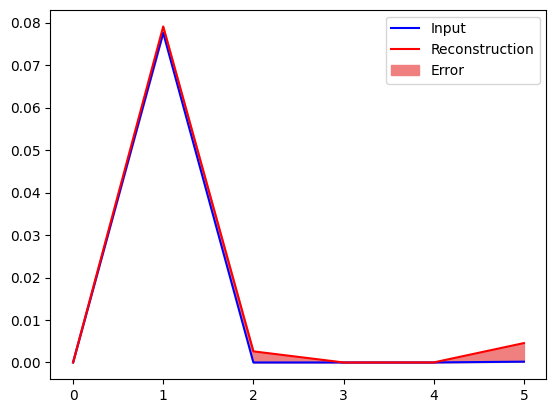

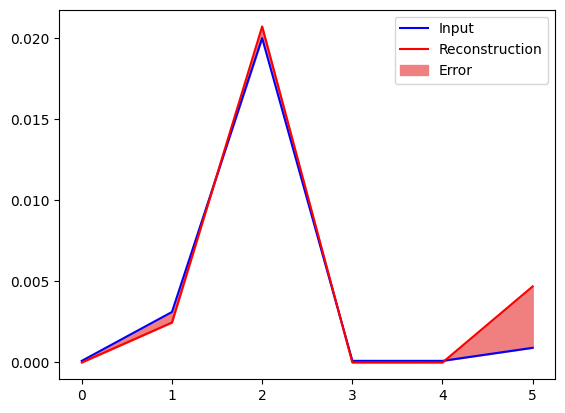

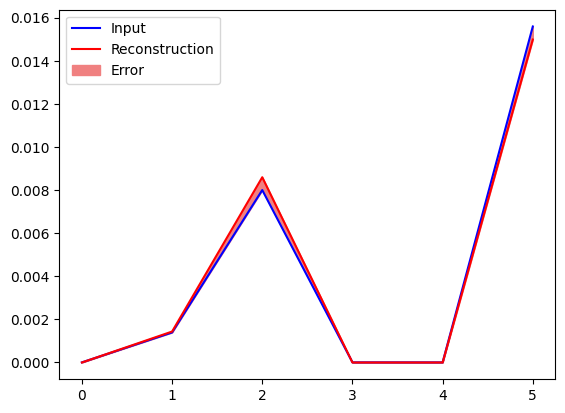

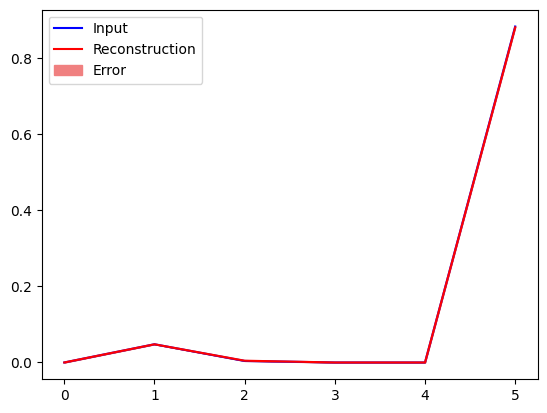

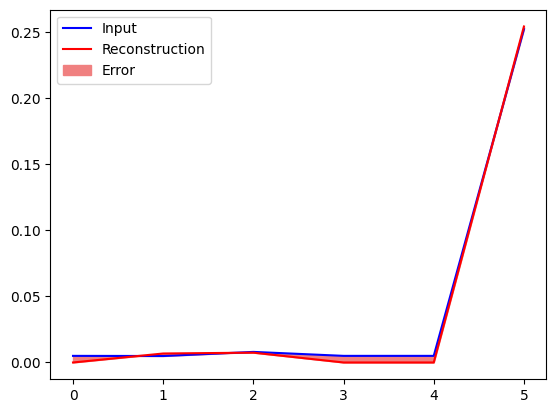

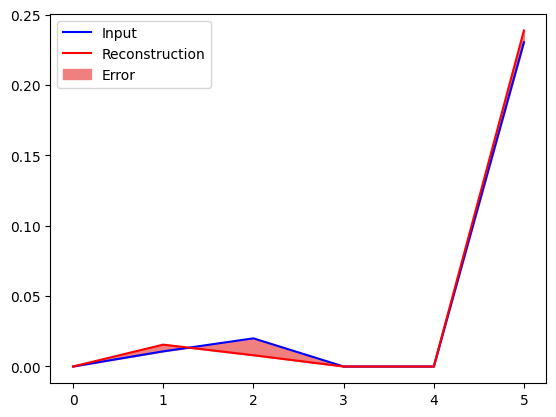

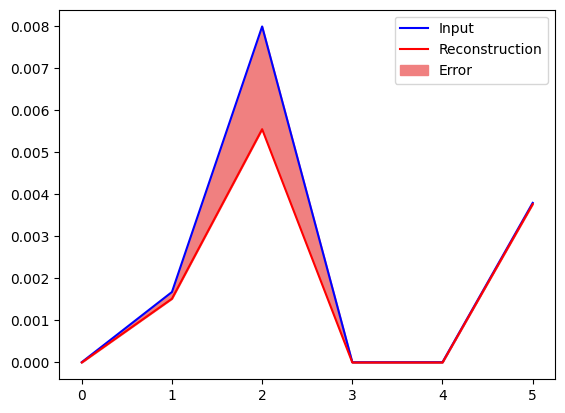

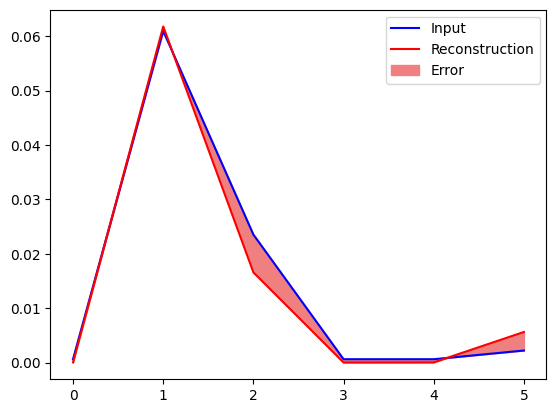

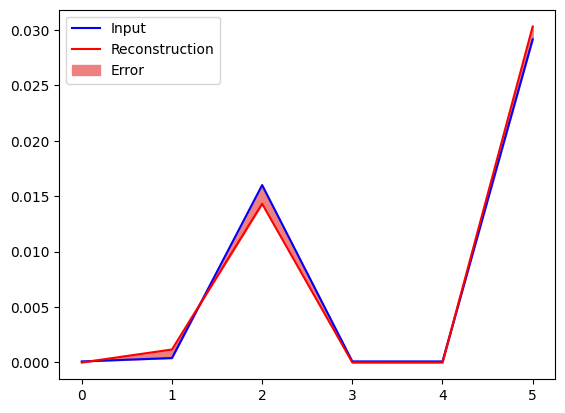

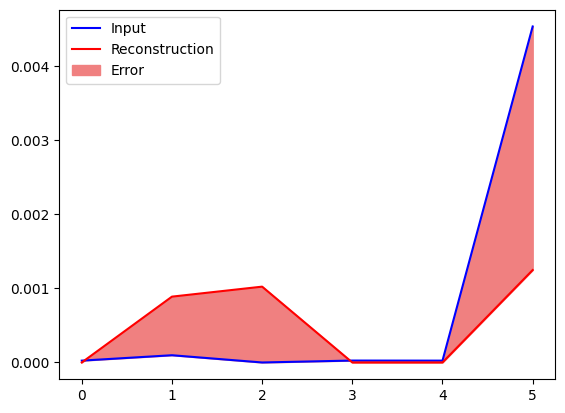

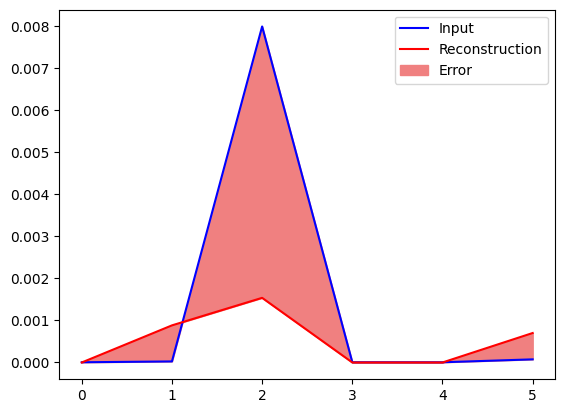

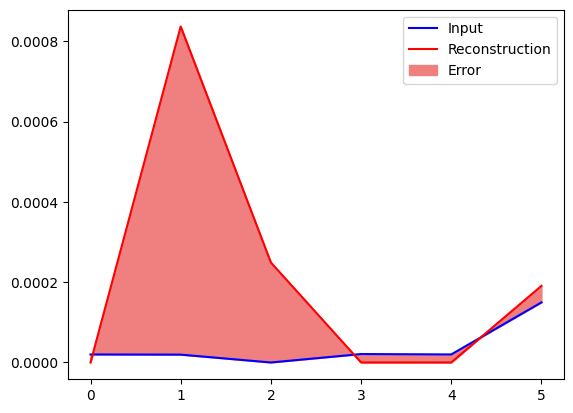

In [ ]:
# encoded_data = autoencoder.encoder(test_data).numpy()
# decoded_data = autoencoder.decoder(encoded_data).numpy()
col = 0
for i in range(20):
  # plt.subplot((i//4) + 1, (col % 2) + 1, i+1)
  plt.plot(test_data_reshaped[i], 'b')
  plt.plot(decoded_data[i], 'r')
  plt.fill_between(np.arange(6), decoded_data[i], test_data_reshaped[i], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()
  col += 1